<a href="https://colab.research.google.com/github/s-c-soma/deep_context_graph/blob/main/code/StatementChecker_KnowledgeGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Two variation: 
1. summarize ->graph :: .buildGraph(.summarize(text))
2. distillation -> graph :: .buildGraph(.distill(text))


# **Env Setup**


In [48]:


# Mount google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=False)


# create folder to write data to
#CIS545_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS545_2020')
#HOMEWORK_FOLDER=os.path.join(CIS545_FOLDER, 'Project')
#os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

Mounted at /content/drive


In [ ]:
!ls '/content/drive/Shared drives/1DeepContextGraph/1DeepContextGraph'

code  documents


In [49]:
file_path = '/content/drive/Shared drives/1DeepContextGraph/1DeepContextGraph/code/data/'

# Library

In [1]:
!pip install sentence-transformers

     |████████████████████████████████| 81kB 6.5MB/s 
     |████████████████████████████████| 2.1MB 9.0MB/s 
     |████████████████████████████████| 1.2MB 56.5MB/s 
     |████████████████████████████████| 901kB 61.0MB/s 
     |████████████████████████████████| 3.3MB 60.2MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.1.0-cp37-none-any.whl size=119615 sha256=1b893d2b89733698fd6761a109ba03e03a84680345fd817fb40339ffa1101bb6
  Stored in directory: /root/.cache/pip/wheels/84/cb/21/1066bff3027215c760ca14a198f698bca8fccb92e33e2327eb
Successfully built sentence-transformers


In [2]:
!pip install LexRank

     |████████████████████████████████| 71kB 6.5MB/s 


In [3]:
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [4]:
#import lexrank.degree_centrality_scores

from lexrank import STOPWORDS, LexRank
from path import Path


In [5]:
import json
import os
# For caculating approximate time to process notebook (IGNORE)
import datetime
datetime.datetime.now()
import argparse
import pandas as pd
import numpy as np
import operator
import pickle as pkl 
import matplotlib.pyplot as plt
import nltk as nl
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import ParameterGrid
import statistics
import random
import warnings
from string import punctuation
from matplotlib import pyplot
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from spacy import displacy 
import nltk
import re
import io
import requests
import time
import gensim
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
import nltk.sentiment
from sentence_transformers import SentenceTransformer, util
import numpy as np
import spacy
from spacy.lang.en import English
import networkx as nx
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, sent_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

# Load Data

In [7]:
data_fox_claim = pd.read_csv(file_path+'/fox_claim_news_processed.csv',low_memory=False)
#data_all_news = pd.read_csv(file_path+'/statement_checker_all.csv',low_memory=False)
data_polifact = pd.read_csv(file_path+'/political_fact_checker_processed.csv',low_memory=False)


In [8]:
data_fox_claim.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'link', 'published', 'title', 'text',
       'site', 'text_distilled', 'topics', 'named_entity_recognition',
       'top_10_freq_word', 'pasts_of_speech'],
      dtype='object')

In [9]:
data_polifact.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'sources', 'urls', 'title', 'summaries',
       'dates', 'ratings', 'text', 'authors', 'publishdate', 'relatedlinks',
       'claims', 'text_distilled', 'topics', 'named_entity_recognition',
       'top_10_freq_word', 'pasts_of_speech'],
      dtype='object')

In [10]:
data_fox_claim['Unnamed: 0'][1]

1

In [11]:
data_fox_claim = data_fox_claim.rename({'Unnamed: 0': 'documentId'}, axis='columns')
data_polifact = data_polifact.rename({'Unnamed: 0': 'documentId'}, axis='columns')

# Methods

## Lemmatization
  
First, the raw words must be converted to root forms.  

In [12]:
def lemmatize(tokenized_words):
  text = [nltk.WordNetLemmatizer().lemmatize(word) for word in tokenized_words]
  return text


## Removing Stop words



In [13]:
english_stopwords = set(stopwords.words('english') + list(punctuation) + [''])

def remove_stopwords(tokenized_words):
  text = [word for word in tokenized_words if word not in english_stopwords]
  return text


## Custom Filtering

Some of the one or two-letter words from the tokenized words are also removed to further cleanse the raw text. 

In [14]:
whitelist = set(['ai', 'ax', 'ca', 'eu', 'go', 'io', 'la', 'ox', 'us', 'uk', 
                 'al', 'ak', 'az', 'ar', 'ca', 'co', 'ct', 'de', 'fl', 'ga', 'hi', 
                 'id', 'il', 'in', 'ia', 'ks', 'ky', 'la', 'me', 'md', 'ma', 'mi',
                 'mn', 'ms', 'mo', 'mt', 'ne', 'nv', 'nh', 'nj', 'nm', 'ny',
                 'nc', 'nd', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn',
                 'tx', 'ut', 'vt', 'va', 'wa', 'wv', 'wi', 'wy' ])
def remove_too_short(tokenized_words):
  text = [word for word in tokenized_words if (len(word) >= 3 or word not in whitelist) ]
  return text

## LDA Analysis


In [15]:
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary

def topics(tokenized_words):
    d = Dictionary([tokenized_words])
    c = [d.doc2bow(tokenized_words)]
    m = LdaModel(c, num_topics=1, id2word=d)
    return list(m.print_topics(num_words=2))
  


## Topics as Simple List of Words

A list of topic terms is compiled as show below. The coefficients in front of each word are dropped as part of simplification. The assumption is that the top two words comprising the topic, are both significant enough to be treated equally. It is important that the goal is to build a reliable prediction model. While there is a risk of oversimplification, if the final model results in a poor accuracy score, the coefficient can always be reintroduced here.

In [16]:
def parseTopics(topics):
   output = []
   words = topics[0][1].split( '+' )
   for word in words:
       output.append( word.split('*')[1].replace( '"', '' ) )
   return output

# Information extraction and knowledge graphs

* https://programmerbackpack.com/python-nlp-tutorial-information-extraction-and-knowledge-graphs/
* https://github.com/bdmarius/python-knowledge-graph

## Methods

In [64]:
def getSentences(text):
    nlp = English()
    nlp.add_pipe(nlp.create_pipe('sentencizer'))
    document = nlp(text)
    return [sent.string.strip() for sent in document.sents]

def printToken(token):
    print(token.text, "->", token.dep_)

def appendChunk(original, chunk):
    return original + ' ' + chunk

def isRelationCandidate(token):
    deps = ["ROOT", "adj", "attr", "agent", "amod"]
    return any(subs in token.dep_ for subs in deps)

def isConstructionCandidate(token):
    deps = ["compound", "prep", "conj", "mod"]
    return any(subs in token.dep_ for subs in deps)

def processSubjectObjectPairs(tokens):
    subject = ''
    object = ''
    relation = ''
    subjectConstruction = ''
    objectConstruction = ''
    for token in tokens:
        printToken(token)
        if "punct" in token.dep_:
            continue
        if isRelationCandidate(token):
            relation = appendChunk(relation, token.lemma_)
        if isConstructionCandidate(token):
            if subjectConstruction:
                subjectConstruction = appendChunk(subjectConstruction, token.text)
            if objectConstruction:
                objectConstruction = appendChunk(objectConstruction, token.text)
        if "subj" in token.dep_:
            subject = appendChunk(subject, token.text)
            subject = appendChunk(subjectConstruction, subject)
            subjectConstruction = ''
        if "obj" in token.dep_:
            object = appendChunk(object, token.text)
            object = appendChunk(objectConstruction, object)
            objectConstruction = ''

    print (subject.strip(), ",", relation.strip(), ",", object.strip())
    return (subject.strip(), relation.strip(), object.strip())

def processSentence(sentence):
    tokens = nlp_model(sentence)
    return processSubjectObjectPairs(tokens)

def printGraph(triples):
    G = nx.Graph()
    for triple in triples:
        G.add_node(triple[0])
        G.add_node(triple[1])
        G.add_node(triple[2])
        G.add_edge(triple[0], triple[1])
        G.add_edge(triple[1], triple[2])

    pos = nx.spring_layout(G)
    plt.figure(figsize=(8, 6), dpi=80)
    nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
            node_size=500, node_color='seagreen', alpha=0.9,
            labels={node: node for node in G.nodes()})
    plt.axis('off')
    plt.show()

## Example and Experiment

In [ ]:
text = "London is the capital and largest city of England and the United Kingdom. Standing on the River " \
           "Thames in the south-east of England, at the head of its 50-mile (80 km) estuary leading to " \
           "the North Sea, London has been a major settlement for two millennia. " \
           "Londinium was founded by the Romans. The City of London, " \
           "London's ancient core − an area of just 1.12 square miles (2.9 km2) and colloquially known as " \
           "the Square Mile − retains boundaries that follow closely its medieval limits." \
           "The City of Westminster is also an Inner London borough holding city status. " \
           "Greater London is governed by the Mayor of London and the London Assembly." \
           "London is located in the southeast of England." \
           "Westminster is located in London." \
           "London is the biggest city in Britain. London has a population of 7,172,036."


In [31]:
body = """ The Chrysler Building, the famous art deco New York skyscraper, will be
 sold for a small fraction of its previous sales price. The building sold fairly 
 quickly after being publicly placed on the market only two months ago. The incentive 
 to sell the building at such a huge loss was due to the soaring rent the owners pay to 
 Cooper Union, a New York college, for the land under the building.' Still the building is 
among the best known in the city, even to people who have never been to New York. """

In [10]:
body = summary
sentences = getSentences(body)
nlp_model = spacy.load('en_core_web_sm')

triples = []
#print (body)
for sentence in sentences:
  triples.append(processSentence(sentence))

In -> prep
a -> det
self -> npadvmod
- -> punct
published -> amod
2015 -> nummod
autobiography -> pobj
, -> punct
Mellon -> nsubj
called -> ROOT
social -> amod
safety -> nmod
net -> amod
programs -> dobj
“ -> punct
Slavery -> compound
Redux -> appos
, -> punct
” -> punct
adding -> advcl
: -> punct
“ -> punct
For -> prep
delivering -> pcomp
their -> poss
votes -> dobj
in -> prep
the -> det
Federal -> compound
Elections -> pobj
, -> punct
they -> nsubjpass
are -> auxpass
awarded -> ccomp
with -> prep
yet -> advmod
more -> amod
and -> cc
more -> conj
freebies -> pobj
: -> punct
food -> compound
stamps -> appos
, -> punct
cell -> compound
phones -> conj
, -> punct
WIC -> compound
payments -> conj
, -> punct
Obamacare -> conj
, -> punct
and -> cc
on -> conj
, -> punct
and -> cc
on -> conj
, -> punct
and -> cc
on -> conj
. -> punct
Mellon they , publish call social net more , autobiography programs votes Elections freebies
Advertisement -> nmod


 -> 
Story -> nsubj
continues -> ROOT
below -

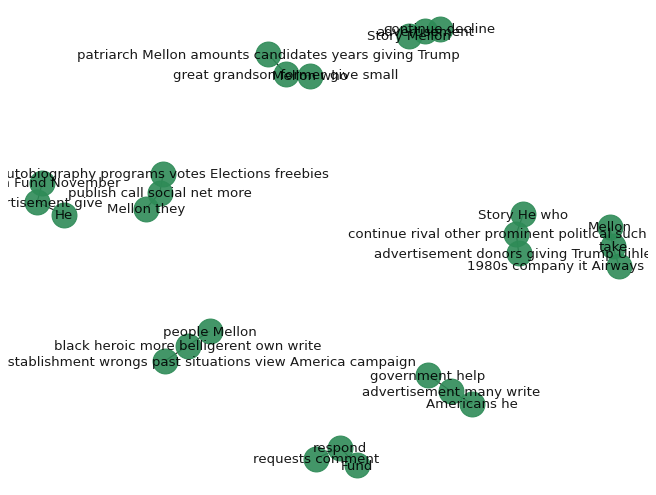

In [11]:
printGraph(triples)  

## Knowledge graph FoxClaim

In [38]:
data_fox_claim.head(1)

,documentId,Unnamed: 0.1,link,published,title,text,site,text_distilled,topics,named_entity_recognition,top_10_freq_word,pasts_of_speech
0,0,0,https://www.foxnews.com/us/violent-crime-los-a...,2021-04-15T22:33:38,"Murders in Los Angeles up nearly 200%, violent...",Murders in Los Angeles County have spiked near...,foxnews,"['murder', 'los', 'angeles', 'nearly', '200', ...","['angeles ', 'crime']","[(Raphael, 'PERSON'), (Warnock, 'PERSON'), (re...","[('los', 5), ('angeles', 5), ('crime', 5), ('f...","[('Murders', 'NNS'), ('Los', 'NNP'), ('Angeles..."


In [39]:
data_fox_claim.columns

Index(['documentId', 'Unnamed: 0.1', 'link', 'published', 'title', 'text',
       'site', 'text_distilled', 'topics', 'named_entity_recognition',
       'top_10_freq_word', 'pasts_of_speech'],
      dtype='object')

In [ ]:
body = data_fox_claim['title'][0]
sentences = getSentences(body)
nlp_model = spacy.load('en_core_web_sm')

triples = []
#print (body)
for sentence in sentences:
  triples.append(processSentence(sentence))

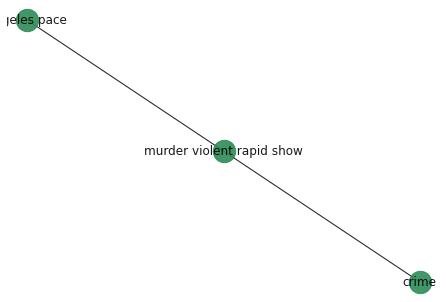

In [45]:
printGraph(triples) 

## Knowledge graph Politifact

In [41]:
data_polifact.head(1)

,documentId,Unnamed: 0.1,sources,urls,title,summaries,dates,ratings,text,authors,publishdate,relatedlinks,claims,text_distilled,topics,named_entity_recognition,top_10_freq_word,pasts_of_speech
0,0,0,politifact,http://www.politifact.com/factchecks/2021/mar/...,\nSays Deborah Birx “traveled a great distance...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,2021-03-29,half-true,\nFormer President Donald Trump didn’t appreci...,Jon Greenberg,2021-03-30,['https://www.cnn.com/2021/03/29/health/pandem...,"National,Coronavirus,Donald Trump","['say', 'deborah', 'birx', 'traveled', 'great'...","['birx ', 'said']","[(Donald, 'PERSON'), (Trump, 'PERSON'), (Biden...","[('birx', 22), ('said', 12), ('family', 10), (...","[('Former', 'NNP'), ('President', 'NNP'), ('Do..."


In [37]:
data_polifact.columns

Index(['documentId', 'Unnamed: 0.1', 'sources', 'urls', 'title', 'summaries',
       'dates', 'ratings', 'text', 'authors', 'publishdate', 'relatedlinks',
       'claims', 'text_distilled', 'topics', 'named_entity_recognition',
       'top_10_freq_word', 'pasts_of_speech'],
      dtype='object')

In [54]:
body = data_polifact['title'][0]
sentences = getSentences(body)
nlp_model = spacy.load('en_core_web_sm')

triples = []
#print (body)
for sentence in sentences:
  triples.append(processSentence(sentence))

Says -> ROOT
Deborah -> compound
Birx -> nsubj
“ -> punct
traveled -> ccomp
a -> det
great -> amod
distance -> dobj
to -> aux
see -> advcl
her -> poss
family -> dobj
for -> prep
Thanksgiving -> pobj
, -> punct
only -> advmod
to -> aux
have -> advcl
them -> nsubj
call -> ccomp
the -> det
police -> dobj
and -> cc
turn -> conj
her -> dobj
in -> prt
. -> punct
Birx them , say great , distance family Thanksgiving police her
She -> nsubj
then -> advmod
... -> punct
resigned -> ROOT
. -> punct
” -> punct
She , resign , 
 ,  , 


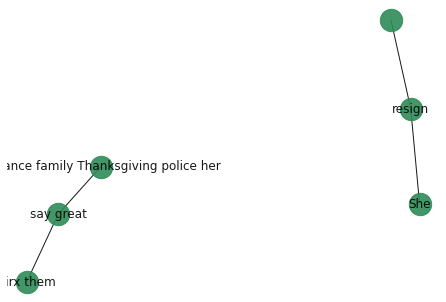

In [55]:
printGraph(triples) 

# Use Case: Political Donation Knowledge Graph for Trump

* news: 
https://www.washingtonpost.com/politics/timothy-mellon-top-donor-to-trump-super-pac-used-racial-stereotypes-to-describe-african-americans-in-his-autobiography/2020/06/18/89206c5a-a742-11ea-b619-3f9133bbb482_story.html

* ref: 
https://programmerbackpack.com/python-nlp-tutorial-information-extraction-and-knowledge-graphs/

In [6]:
!pip install newspaper3k

     |████████████████████████████████| 215kB 13.9MB/s 
     |████████████████████████████████| 92kB 9.2MB/s 
     |████████████████████████████████| 7.4MB 13.4MB/s 
     |████████████████████████████████| 81kB 10.3MB/s 
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-cp37-none-any.whl size=3358 sha256=9fcb5e494176194454aa7eb695363baabea58c97a8456c72d0274121ebaed8cb
  Stored in directory: /root/.cache/pip/wheels/de/03/ca/778e3a7a627e3d98836cc890e7cb40c7575424cfd3340f40ed
  Created wheel for jieba3k: filename=jieba3k-0.35.1-cp37-none-any.whl size=7398406 sha256=3a856f840d3a5806574d1bbcc1d45aa865cf51b4ba48dd48a4e7b5ef6f27ff2f
  Stored in directory: /root/.cache/pip/wheels/83/15/9c/a3f1f67e7f7181170ad37d32e503c35da20627c013f438ed34
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-cp37-none-any.whl size=13538 sha256=70f1413095bfffbaa837d7a306dc00136e8303dff94fac41e1bc4d095ef5b9c6
  Stored in directory: /root/.cache/pip/wheels/81/2b/43/a02ede72324dd40cdd7ca53aad718c

## Get Text
https://analyticsindiamag.com/hands-on-guide-to-extractive-text-summarization-with-bertsum/

In [110]:
from newspaper import fulltext
import requests
article_url="https://www.washingtonpost.com/politics/timothy-mellon-top-donor-to-trump-super-pac-used-racial-stereotypes-to-describe-african-americans-in-his-autobiography/2020/06/18/89206c5a-a742-11ea-b619-3f9133bbb482_story.html "
article = fulltext(requests.get(article_url).text)
print(article)

In a self-published 2015 autobiography, Mellon called social safety net programs “Slavery Redux,” adding: “For delivering their votes in the Federal Elections, they are awarded with yet more and more freebies: food stamps, cell phones, WIC payments, Obamacare, and on, and on, and on. The largess is funded by the hardworking folks, fewer and fewer in number, who are too honest or too proud to allow themselves to sink into this morass.”

Advertisement

Story continues below advertisement

Mellon declined to comment.

The Wyoming-based donor, whose family fortune dates to the Gilded Age, gave his first major pro-Trump donation in April, with a $10 million check to America First Action, the main super PAC supporting the president’s reelection. His donations are the biggest known contributions to the group by far, and he is also a top donor to GOP congressional super PACs, according to campaign finance records.

America First Action, a super PAC chaired by Linda McMahon, former head of the 

## Get Summary from Text

In [9]:
## computed using my BERT Model Summarization
summary = '''
In a self-published 2015 autobiography, Mellon called social safety net programs “Slavery Redux,” adding: “For delivering their votes in the Federal Elections, they are awarded with yet more and more freebies: food stamps, cell phones, WIC payments, Obamacare, and on, and on, and on. Advertisement

Story continues below advertisement

Mellon declined to comment. Mellon, who is the great-grandson of Mellon family patriarch and banker Thomas Mellon, and grandson of Andrew W. Mellon, the former Treasury Department secretary, had given smaller amounts to state and federal GOP candidates for years, 
but ramped up his giving under Trump, campaign finance records show. Story continues below advertisement

He now rivals other prominent donors who have increased their political giving under Trump, 
such as shipping supplies magnate Richard Uihlein and Stephen Schwarzman, the Blackstone chairman and chief executive. 
Black people, in spite of heroic efforts by the ‘Establishment’ to right the wrongs of the past, became even more belligerent and unwilling to pitch in to improve their own situations,” Mellon wrote, describing his view of America during Reagan’s 1984 reelection campaign. Advertisement

Two decades later, too many Americans are still relying on the government for help, 
he wrote. In the 1980s, Mellon took over a rail company called Guilford Transportation Industries and rebranded it after purchasing Pan Am Airways from bankruptcy in the 1990s. Advertisement

He gave another $10 million to the Congressional Leadership Fund in November 2019. The Congressional Leadership Fund did not respond to requests for comment.'''

## Create Graph

In [14]:
body = summary
sentences = getSentences(body)
nlp_model = spacy.load('en_core_web_sm')

triples = []
#print (body)
for sentence in sentences:
  triples.append(processSentence(sentence))

In -> prep
a -> det
self -> npadvmod
- -> punct
published -> amod
2015 -> nummod
autobiography -> pobj
, -> punct
Mellon -> nsubj
called -> ROOT
social -> amod
safety -> nmod
net -> amod
programs -> dobj
“ -> punct
Slavery -> compound
Redux -> appos
, -> punct
” -> punct
adding -> advcl
: -> punct
“ -> punct
For -> prep
delivering -> pcomp
their -> poss
votes -> dobj
in -> prep
the -> det
Federal -> compound
Elections -> pobj
, -> punct
they -> nsubjpass
are -> auxpass
awarded -> ccomp
with -> prep
yet -> advmod
more -> amod
and -> cc
more -> conj
freebies -> pobj
: -> punct
food -> compound
stamps -> appos
, -> punct
cell -> compound
phones -> conj
, -> punct
WIC -> compound
payments -> conj
, -> punct
Obamacare -> conj
, -> punct
and -> cc
on -> conj
, -> punct
and -> cc
on -> conj
, -> punct
and -> cc
on -> conj
. -> punct
Mellon they , publish call social net more , autobiography programs votes Elections freebies
Advertisement -> nmod


 -> 
Story -> nsubj
continues -> ROOT
below -

In [16]:
triples

[('Mellon they',
  'publish call social net more',
  'autobiography programs votes Elections freebies'),
 ('Story Mellon', 'continue decline', 'advertisement'),
 ('Mellon who',
  'great grandson former give small',
  'patriarch Mellon amounts candidates years giving Trump'),
 ('Story He who',
  'continue rival other prominent political such chief',
  'advertisement donors giving Trump Uihlein'),
 ('people Mellon',
  'black heroic more belligerent own write',
  'spite efforts Establishment wrongs past situations view America campaign'),
 ('Americans he', 'advertisement many write', 'government help'),
 ('Mellon', 'take', '1980s company it Airways bankruptcy 1990s'),
 ('He', 'advertisement give', 'million Fund November'),
 ('Fund', 'respond', 'requests comment')]

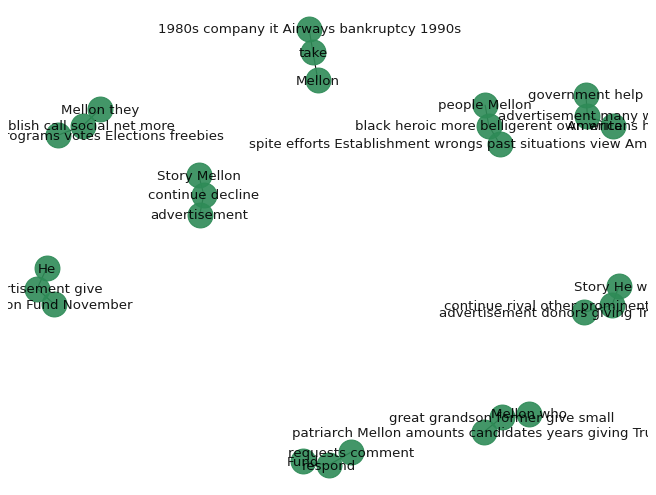

In [15]:
printGraph(triples)  

# Semantic Relationships

In [17]:
from nltk import Tree

def buildTree(token):
    if token.n_lefts + token.n_rights > 0:
        return Tree(token, [buildTree(child) for child in token.children])
    else:
        return buildTree(token)

In [18]:
class Relation:

    __hypernym: str
    __hyponym: str

    def __init__(self, hypernym, hyponym):
        self.__hypernym = hypernym
        self.__hyponym = hyponym

    def getHypernym(self):
        return self.__hypernym

    def getHyponym(self):
        return self.__hyponym

In [20]:
!pip install relation

ERROR: Could not find a version that satisfies the requirement relation (from versions: none)
ERROR: No matching distribution found for relation


In [21]:
#from relation import Relation

class RelationProvider:

    __relations: [Relation]

    def __init__(self, relations=[Relation]):
        self.__relations = relations

    def getRelations(self):
        return self.__relations

In [22]:
#import wikipedia


class TextExtractor:

    __pageTitle: str
    __pageId: str

    def __init__(self, pageTitle, pageId):
        self.__pageTitle = pageTitle
        self.__pageId = pageId

    def extract(self):
        page = wikipedia.page(title=self.__pageTitle, pageid=self.__pageId)
        f = open("./text/" + self.__pageTitle + ".txt", "w")
        f.write(page.content)
        f.close()

    def getText(self):
        f = open("./text/" + self.__pageTitle + ".txt", "r")
        return f.read()

In [23]:
#from text_extractor import TextExtractor


class TextExtractorPipe:

    __textExtractors: [TextExtractor]

    def __init__(self):
        self.__textExtractors = []

    def addTextExtractor(self, textExtractor: TextExtractor):
        self.__textExtractors.append(textExtractor)

    def extract(self) -> str:
        result = ''
        for textExtractor in self.__textExtractors:
            result = result + textExtractor.getText()
        return result

In [24]:
from spacy.matcher import Matcher
from abc import abstractmethod
from spacy.tokens import Doc
# from relation import Relation


class PatternMatcher:


    def __init__(self, pattern, nlp, matcherId):
        self._nlp = nlp
        self._matcher = Matcher(nlp.vocab)
        self._matcher.add(matcherId, None, pattern)

    @abstractmethod
    def getRelations(self, doc: Doc) -> [Relation]:
        ...

In [25]:
# from pattern_matcher import PatternMatcher
from spacy.tokens import Doc
# from relation import Relation


class AndOtherPatternMatcher(PatternMatcher):


    def __init__(self, nlp):
        pattern = [{'POS': 'NOUN'},
                   {'LOWER': 'and'},
                   {'LOWER': 'other'},
                   {'POS': 'NOUN'}]
        PatternMatcher.__init__(self, pattern, nlp, "andOther")

    def getRelations(self, doc: Doc) -> [Relation]:
        relations = []
        matches = self._matcher(doc)
        for match_id, start, end in matches:
            span = doc[start:end]
            firstToken = span.root.head
            results = [firstToken]
            while firstToken and firstToken.head.pos_ == "NOUN":
                results.append(firstToken.head)
                firstToken = firstToken.head
            hypernym = span.text.split()[-1]
            relations.append(Relation(hypernym, span.text.split()[0]))
            if len(results) > 0:
                for result in results:
                    relations.append(Relation(hypernym, result.text))
        return relations

## Implementation

In [26]:
hypernym = span.text.split()[-1]

NameError: ignored

In [27]:
relations.append(Relation(hypernym, span.text.split()[0]))

NameError: ignored

In [28]:
# from pattern_matcher import PatternMatcher
from spacy.tokens import Doc
# from relation import Relation


class OrOtherPatternMatcher(PatternMatcher):

    def __init__(self, nlp):
        pattern = [{'POS': 'NOUN'},
                   {'LOWER': 'or'},
                   {'LOWER': 'other'},
                   {'POS': 'NOUN'}]
        PatternMatcher.__init__(self, pattern, nlp, "orOther")

    def getRelations(self, doc: Doc) -> [Relation]:
        relations = []
        matches = self._matcher(doc)
        for match_id, start, end in matches:
            span = doc[start:end]
            firstToken = span.root.head
            results = [firstToken]
            while firstToken and firstToken.head.pos_ == "NOUN":
                results.append(firstToken.head)
                firstToken = firstToken.head
            hypernym = span.text.split()[-1]
            relations.append(Relation(hypernym, span.text.split()[0]))
            if len(results) > 0:
                for result in results:
                    relations.append(Relation(hypernym, result.text))
        return relations

In [29]:
# from pattern_matcher import PatternMatcher
from spacy.tokens import Doc
# from relation import Relation


class EspeciallyPatternMatcher(PatternMatcher):

    def __init__(self, nlp):
        pattern = [{'POS': 'NOUN'},
                   {'IS_PUNCT': True, 'OP': '?'},
                   {'LOWER': 'especially'},
                   {'POS': 'NOUN'}]
        PatternMatcher.__init__(self, pattern, nlp, "especially")

    def getRelations(self, doc: Doc) -> [Relation]:
        relations = []
        matches = self._matcher(doc)
        for match_id, start, end in matches:
            span = doc[start:end]
            candidates = set()
            for sent in doc.sents:
                for token in sent:
                    # Find relation
                    if token.i == span.root.i:
                        for token2 in sent:
                            # First hyponym
                            if token2.head.i == token.i:
                                for token3 in sent:
                                    startToken = token3
                                    while startToken and startToken.head.i != sent.root.i and startToken.i != token2.i:
                                        if startToken.pos_ == "NOUN":
                                            candidates.add(startToken)
                                        startToken = startToken.head
            if len(candidates) > 0:
                hypernym = span.text.split()[0].replace(',', '')
                for candidate in candidates:
                    relations.append(Relation(hypernym, candidate.text))

        return relations

In [30]:
# from pattern_matcher import PatternMatcher
from spacy.tokens import Doc
# from relation import Relation


class IncludingPatternMatcher(PatternMatcher):

    def __init__(self, nlp):
        pattern = [{'POS': 'NOUN'},
                   {'IS_PUNCT': True, 'OP': '?'},
                   {'LOWER': 'including'},
                   {'POS': 'NOUN'}]
        PatternMatcher.__init__(self, pattern, nlp, "including")

    def getRelations(self, doc: Doc) -> [Relation]:
        relations = []
        matches = self._matcher(doc)
        for match_id, start, end in matches:
            span = doc[start:end]
            for sent in doc.sents:
                for token in sent:
                    # Find the relation
                    if token.text == "including" and token.head.i == span.root.i:
                        for token2 in sent:
                            # First hyponym
                            if token2.head.i == token.i:
                                results = set()
                                results.add(span.text.split()[-1])
                                # Other hyponyms
                                for token3 in sent:
                                    startToken = token3
                                    while startToken and startToken.head.i != sent.root.i and startToken.i != token2.i:
                                        if startToken.pos_ == "NOUN":
                                            results.add(startToken.text)
                                        startToken = startToken.head
                                if len(results) > 0:
                                    hypernym = span.text.split()[0].replace(',', '')
                                    for result in results:
                                        relations.append(Relation(hypernym, result))
        return relations

In [31]:
# from pattern_matcher import PatternMatcher
from spacy.tokens import Doc
# from relation import Relation


class SuchAsPatternMatcher(PatternMatcher):


    def __init__(self, nlp):
        pattern = [{'POS': 'NOUN'},
                   {'IS_PUNCT': True, 'OP': '?'},
                   {'LOWER': 'such'},
                   {'LOWER': 'as'},
                   {'POS': 'NOUN'}]
        PatternMatcher.__init__(self, pattern, nlp, "suchAs")

    def getRelations(self, doc: Doc) -> [Relation]:
        relations = []
        matches = self._matcher(doc)
        for match_id, start, end in matches:
            span = doc[start:end]
            hypernym = span.root.text
            hyponym = span.text.split()[-1]
            relations.append(Relation(hypernym, hyponym))
            for right in span.rights:
                if right.pos_ == "NOUN":
                    relations.append(Relation(hypernym, right.text))
        return relations

In [33]:
# from pattern_matcher import PatternMatcher
# from relation import Relation
from spacy.tokens import Doc


class MatcherPipe:

    __matchers: [PatternMatcher]

    def __init__(self):
        self.__matchers = []

    def addMatcher(self, matcher: PatternMatcher):
        self.__matchers.append(matcher)

    def extract(self, doc: Doc) -> [Relation]:
        results = []
        for matcher in self.__matchers:
            results.extend(matcher.getRelations(doc))
        return results

## knowledge_graph.py

In [34]:
# from relation import Relation
import networkx as nx
import matplotlib.pyplot as plt

class KnowledgeGraph:

    __relations: [Relation]
    __graph: nx.Graph
    __colors: {}

    def __init__(self, relations):
        self.__relations = relations
        self.__graph = nx.Graph()
        self.__colors = {}

    def build(self):
        for relation in self.__relations:
            self.__graph.add_node(relation.getHypernym())
            self.__colors[relation.getHypernym()] = '#e34234'
            self.__graph.add_node(relation.getHyponym())
            self.__colors[relation.getHyponym()] = '#009966'
            self.__graph.add_edge(relation.getHypernym(), relation.getHyponym())

    def show(self):
        pos = nx.spring_layout(self.__graph)
        plt.figure()
        colorMap = []
        for node in self.__graph.nodes:
            colorMap.append(self.__colors[node])
        nx.draw(self.__graph, pos, edge_color='black', width=1, linewidths=1,
                node_size=500, node_color=colorMap, alpha=0.9,
                labels={node: node for node in self.__graph.nodes()})
        plt.axis('off')
        plt.show()

## build_knowledge_graph.py

In [ ]:
from text_extractor import TextExtractor
from and_other_pattern_matcher import AndOtherPatternMatcher
from such_as_pattern_matcher import SuchAsPatternMatcher
from or_other_pattern_matcher import OrOtherPatternMatcher
from including_pattern_matcher import IncludingPatternMatcher
from especially_pattern_matcher import EspeciallyPatternMatcher
from text_extractor_pipe import TextExtractorPipe
from knowledge_graph import KnowledgeGraph
from matcher_pipe import MatcherPipe
import spacy

textExtractor1 = TextExtractor("WWII", "Q362")
textExtractor1.extract()
textExtractor2 = TextExtractor("London", "Q84")
textExtractor2.extract()
textExtractor3 = TextExtractor("Paris", "Q90")
textExtractor3.extract()
textExtractor4 = TextExtractor("World War I", "Q361")
textExtractor4.extract()
textExtractorPipe = TextExtractorPipe()
textExtractorPipe.addTextExtractor(textExtractor1)
textExtractorPipe.addTextExtractor(textExtractor2)
textExtractorPipe.addTextExtractor(textExtractor3)
textExtractorPipe.addTextExtractor(textExtractor4)


nlp = spacy.load('en_core_web_sm')
nlp.add_pipe(nlp.create_pipe('sentencizer')) # updated
doc = nlp(textExtractorPipe.extract())

andOtherPatternMatcher = AndOtherPatternMatcher(nlp)
suchAsMatcher = SuchAsPatternMatcher(nlp)
orOtherMatcher = OrOtherPatternMatcher(nlp)
includingPatternMatcher = IncludingPatternMatcher(nlp)
especiallyPatternMatcher = EspeciallyPatternMatcher(nlp)
matcherPipe = MatcherPipe()
matcherPipe.addMatcher(andOtherPatternMatcher)
matcherPipe.addMatcher(suchAsMatcher)
matcherPipe.addMatcher(orOtherMatcher)
matcherPipe.addMatcher(includingPatternMatcher)
matcherPipe.addMatcher(especiallyPatternMatcher)
relations = matcherPipe.extract(doc)

for relation in relations:
    print (relation.getHypernym(), relation.getHyponym())

knowledgeGraph = KnowledgeGraph(relations)
knowledgeGraph.build()
knowledgeGraph.show()

# Question Answering with Pretrained Transformers Using PyTorch

https://towardsdatascience.com/question-answering-with-pretrained-transformers-using-pytorch-c3e7a44b4012

## Library Setup

In [95]:
!pip install transformers

In [96]:
from transformers import pipeline

## Build the QA Pipeline

In [98]:
question_answering = pipeline("question-answering")

## Define the Context and Question to Ask

In [ ]:
text = '''Mellon from Pan Am Systems donated $10 million to Trump's campaign.
An heir to the Mellon banking fortune and the grandson of former U.S. 
Treasury Secretary, Andrew Mellon, his is among the biggest donations this 
election cycle. He owns the largest regional railroad in North America,
 Pan Am Railways, which went up for sale in July. He's been notably reclusive and absent from politics. 
Republican operatives reportedly had to look his name up on Google when he came forward to help.'''

In [102]:
text = '''Timothy Mellon, Pan Am Systems - $10 million
An heir to the Mellon banking fortune and the grandson of former U.S. Treasury Secretary, 
Andrew Mellon, his is among the biggest donations this election cycle. He owns the largest 
regional railroad in North America, Pan Am Railways, which went up for sale in July. 
He's been notably reclusive and absent from politics. 
Republican operatives reportedly had to look his name up on Google when he came forward to help.'''

In [120]:
text = summary = '''
In a self-published 2015 autobiography, Mellon called social safety net programs “Slavery Redux,” adding: “For delivering their votes in the Federal Elections, they are awarded with yet more and more freebies: food stamps, cell phones, WIC payments, Obamacare, and on, and on, and on. Advertisement
Story continues below advertisement
Mellon declined to comment. Mellon, who is the great-grandson of Mellon family patriarch and banker Thomas Mellon, and grandson of Andrew W. Mellon, the former Treasury Department secretary, had given smaller amounts to state and federal GOP candidates for years, 
but ramped up his giving under Trump, campaign finance records show. Story continues below advertisement

He now rivals other prominent donors who have increased their political giving under Trump, 
such as shipping supplies magnate Richard Uihlein and Stephen Schwarzman, the Blackstone chairman and chief executive. 
Black people, in spite of heroic efforts by the ‘Establishment’ to right the wrongs of the past, became even more belligerent and unwilling to pitch in to improve their own situations,” Mellon wrote, describing his view of America during Reagan’s 1984 reelection campaign. Advertisement

Two decades later, too many Americans are still relying on the government for help, 
he wrote. In the 1980s, Mellon took over a rail company called Guilford Transportation Industries and rebranded it after purchasing Pan Am Airways from bankruptcy in the 1990s. Advertisement

He gave another $10 million to the Congressional Leadership Fund in November 2019. The Congressional Leadership Fund did not respond to requests for comment.'''

In [124]:
context = text

In [125]:
question = "Who gave the election donation?"

## Perform Q&A

In [126]:
result = question_answering(question=question, context=context)
print("Answer:", result['answer'])
print("Score:", result['score'])

Answer: Congressional Leadership Fund
Score: 0.5438297390937805


# Upgrade Mehtods

In [8]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

## Input Test

In [70]:
text = '''Mellon from Pan Am Systems donated $10 million to Trump's campaign.
An heir to the Mellon banking fortune and the grandson of former U.S. 
Treasury Secretary, Andrew Mellon, his is among the biggest donations this 
election cycle. He owns the largest regional railroad in North America,
 Pan Am Railways, which went up for sale in July. He's been notably reclusive and absent from politics. 
Republican operatives reportedly had to look his name up on Google when he came forward to help.'''

## get_NER

In [20]:
doc = nlp("Mellon gave 100 million donation to Trump's campaign")

for tok in doc:
  print(tok.text, "...", tok.dep_, "....", tok.ent_type_)

Mellon ... nsubj .... ORG
gave ... ROOT .... 
100 ... compound .... CARDINAL
million ... nummod .... CARDINAL
donation ... dobj .... 
to ... prep .... 
Trump ... poss .... PERSON
's ... case .... 
campaign ... pobj .... 


In [71]:
#summary = article
summary = text

In [93]:
doc = nlp(summary)

for tok in doc:
  print(tok.text, "...", tok.dep_, "--", tok.ent_type_)
  print(tok.text, '=>',tok.pos_,'=>',tok.tag_)
  print("#########")

Mellon ... nsubj -- ORG
Mellon => PROPN => NNP
#########
from ... prep -- 
from => ADP => IN
#########
Pan ... compound -- ORG
Pan => PROPN => NNP
#########
Am ... compound -- ORG
Am => PROPN => NNP
#########
Systems ... pobj -- ORG
Systems => PROPN => NNPS
#########
donated ... ROOT -- 
donated => VERB => VBD
#########
$ ... quantmod -- MONEY
$ => SYM => $
#########
10 ... compound -- MONEY
10 => NUM => CD
#########
million ... dobj -- MONEY
million => NUM => CD
#########
to ... prep -- 
to => ADP => IN
#########
Trump ... poss -- PERSON
Trump => PROPN => NNP
#########
's ... case -- 
's => PART => POS
#########
campaign ... pobj -- 
campaign => NOUN => NN
#########
. ... punct -- 
. => PUNCT => .
#########

 ...  -- 

 => SPACE => _SP
#########
An ... det -- 
An => DET => DT
#########
heir ... npadvmod -- 
heir => NOUN => NN
#########
to ... prep -- 
to => ADP => IN
#########
the ... det -- 
the => DET => DT
#########
Mellon ... compound -- ORG
Mellon => PROPN => NNP
#########
bankin

### Visualize NER

In [94]:
displacy.render(doc, style='ent', jupyter=True)

### Visualize POS

https://stackabuse.com/python-for-nlp-parts-of-speech-tagging-and-named-entity-recognition/

In [91]:
displacy.render(doc, style='dep', jupyter=True, options={'distance': 85})

In [90]:
for word in doc:
    print(f'{word.text:{12}} {word.pos_:{10}} {word.tag_:{8}} {spacy.explain(word.tag_)}')

Mellon       PROPN      NNP      noun, proper singular
from         ADP        IN       conjunction, subordinating or preposition
Pan          PROPN      NNP      noun, proper singular
Am           PROPN      NNP      noun, proper singular
Systems      PROPN      NNPS     noun, proper plural
donated      VERB       VBD      verb, past tense
$            SYM        $        symbol, currency
10           NUM        CD       cardinal number
million      NUM        CD       cardinal number
to           ADP        IN       conjunction, subordinating or preposition
Trump        PROPN      NNP      noun, proper singular
's           PART       POS      possessive ending
campaign     NOUN       NN       noun, singular or mass
.            PUNCT      .        punctuation mark, sentence closer

            SPACE      _SP      None
An           DET        DT       determiner
heir         NOUN       NN       noun, singular or mass
to           ADP        IN       conjunction, subordinating or prep

## get_entities

In [74]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [32]:
get_entities("Mellon gave 100 million donation to Trump's campaign")

['Mellon', '100 million 100 campaign']

In [75]:
get_entities(summary)

['when  he', 'reportedly  Google']

In [76]:
sentences = sent_tokenize(summary)
sentences

["Mellon from Pan Am Systems donated $10 million to Trump's campaign.",
 'An heir to the Mellon banking fortune and the grandson of former U.S. \nTreasury Secretary, Andrew Mellon, his is among the biggest donations this \nelection cycle.',
 'He owns the largest regional railroad in North America,\n Pan Am Railways, which went up for sale in July.',
 "He's been notably reclusive and absent from politics.",
 'Republican operatives reportedly had to look his name up on Google when he came forward to help.']

## entity_pairs

In [77]:
entity_pairs = []

for i in tqdm(sentences):
  entity_pairs.append(get_entities(i))

100%|██████████| 5/5 [00:00<00:00, 11.56it/s]


In [78]:
entity_pairs

[['Mellon', '$ 10 campaign'],
 ['U.S. Andrew his', 'biggest  donations'],
 ['regional Pan Am which', 'July'],
 ['He', 'notably  politics'],
 ['when  he', 'reportedly  Google']]

## get_relation

In [79]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern ## update pattern using Hearst Patteren 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [80]:
get_relation("Mellon gave 100million donation to Trump's campaign")

'gave'

In [81]:
relations = [get_relation(i) for i in tqdm(sentences)]

100%|██████████| 5/5 [00:00<00:00,  8.00it/s]


In [82]:
pd.Series(relations).value_counts()[:50]

is among    1
had         1
been        1
owns        1
donated     1
dtype: int64

## Building Knowledge Graph: Method 1

In [83]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [84]:

# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

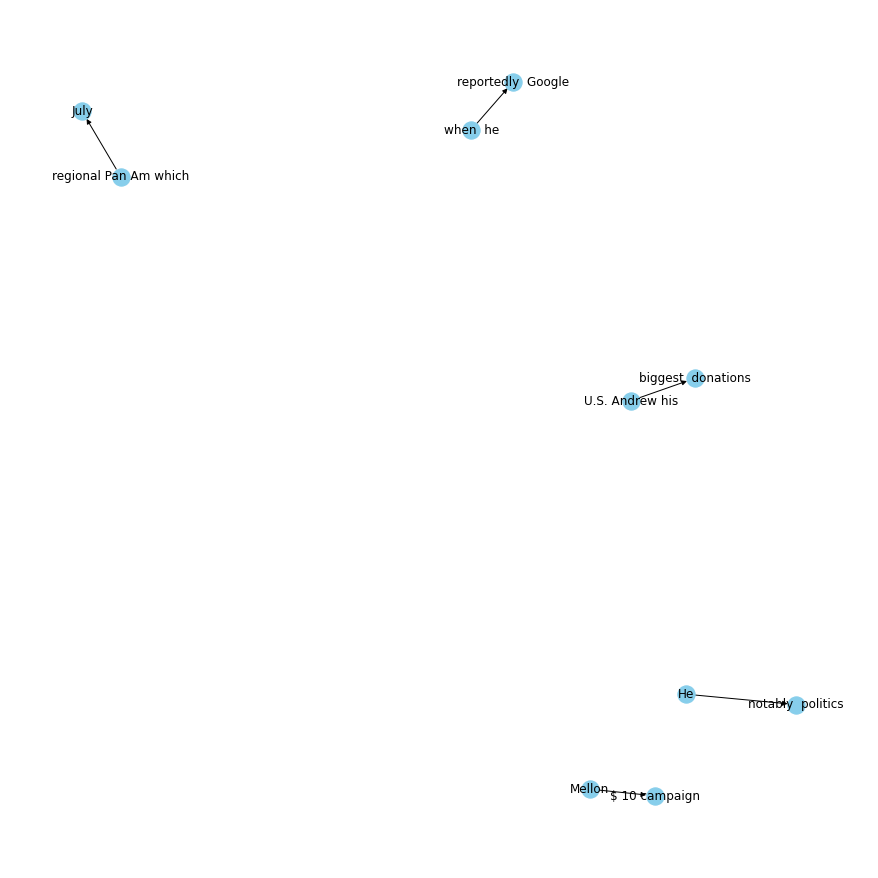

In [85]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [62]:
kg_df['edge'].unique()

array(['donated', 'is among', 'owns', 'been', 'had'], dtype=object)

### To CSV

In [50]:
file_path = '/content/drive/Shared drives/1DeepContextGraph/1DeepContextGraph/code/data/'

In [86]:
kg_df.head()
#kg_df.to_csv(file_path+"kg_path.csv")

,source,target,edge
0,Mellon,$ 10 campaign,donated
1,U.S. Andrew his,biggest donations,is among
2,regional Pan Am which,July,owns
3,He,notably politics,been
4,when he,reportedly Google,had


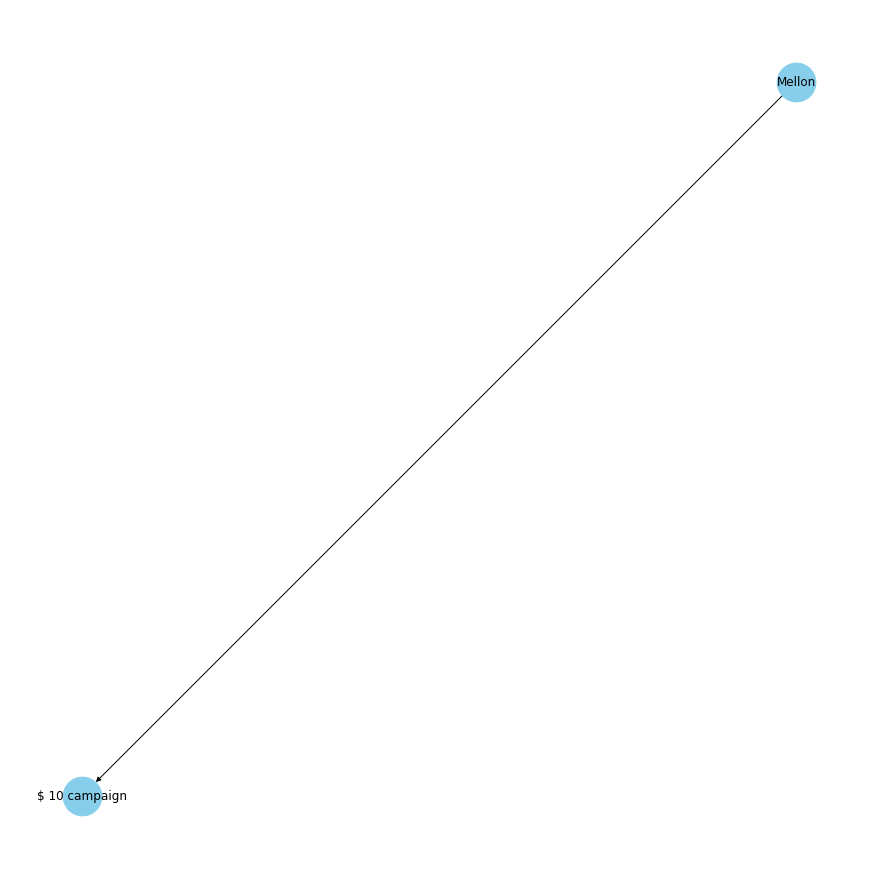

In [87]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="donated"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [ ]:
kg_df[kg_df['source']=="Mellon"]

In [ ]:

G=nx.from_pandas_edgelist(kg_df[kg_df['source']=="Mellon"], "edge", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [ ]:

G=nx.from_pandas_edgelist(kg_df[kg_df['target']=="advertisement"], "edge", "source", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

## Building Knowledge Graph: Method 2

In [88]:
body = summary
sentences = getSentences(body)
nlp_model = spacy.load('en_core_web_sm')

triples = []
#print (body)
for sentence in sentences:
  triples.append(processSentence(sentence))


Mellon -> nsubj
from -> prep
Pan -> compound
Am -> compound
Systems -> pobj
donated -> ROOT
$ -> quantmod
10 -> compound
million -> dobj
to -> prep
Trump -> poss
's -> case
campaign -> pobj
. -> punct
Mellon , donate , Systems million campaign
An -> det
heir -> dep
to -> prep
the -> det
Mellon -> compound
banking -> compound
fortune -> pobj
and -> cc
the -> det
grandson -> conj
of -> prep
former -> amod
U.S. -> nmod

 -> 
Treasury -> compound
Secretary -> pobj
, -> punct
Andrew -> compound
Mellon -> appos
, -> punct
his -> nsubj
is -> ROOT
among -> prep
the -> det
biggest -> amod
donations -> pobj
this -> det

 -> 
election -> compound
cycle -> attr
. -> punct
his , former be big cycle , fortune Secretary donations
He -> nsubj
owns -> ROOT
the -> det
largest -> amod
regional -> amod
railroad -> dobj
in -> prep
North -> compound
America -> pobj
, -> punct

  -> 
Pan -> compound
Am -> compound
Railways -> dobj
, -> punct
which -> nsubj
went -> relcl
up -> prt
for -> prep
sale -> pobj
in 

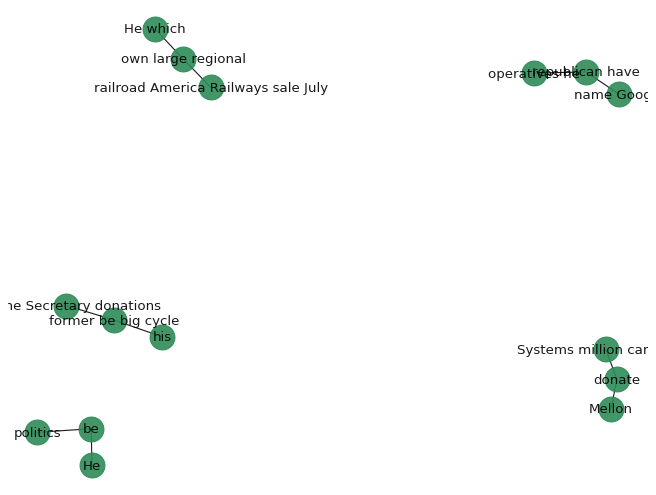

In [89]:
printGraph(triples) 

order 2-4

1. given url -> provide a df containing all the binary relationship
2. Add "mapping data structure" to the df
3. Visualize: Netwroks
4. Visualize NER; POS; Relationships; => binary graph
5. Transitive micro graph
6. ** Disambiguation

2,4,5